# Anomaly Detection using GANs

Dataset from: Iman Sharafaldin, Arash Habibi Lashkari, and Ali A. Ghorbani, “Toward Generating a New Intrusion Detection Dataset and Intrusion Traffic Characterization”, 4th International Conference on Information Systems Security and Privacy (ICISSP), Portugal, January 2018

In [1]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input, BatchNormalization, LeakyReLU, Dense, Reshape, Flatten, Activation 
from tensorflow.keras.layers import Dropout, multiply, GaussianNoise, MaxPooling2D, concatenate
from tensorflow.keras import initializers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint

2022-09-30 13:29:17.512575: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import collections
import sys

import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd

from sklearn.metrics import roc_curve, auc,precision_recall_fscore_support, average_precision_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix,accuracy_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split

import seaborn as sns

from tqdm import tqdm

import helper_functions

pd.options.display.max_columns = None

In [3]:
filename = '../data/preprocessed_data.pickle'
figure_path = '../report/best/gan/'

input_file = open(filename,'rb')
preprocessed_data = pickle.load(input_file)
input_file.close()

In [4]:
le = preprocessed_data['le']
x_train = preprocessed_data['x_train']
y_train = preprocessed_data['y_train']
x_test = preprocessed_data['x_test']
y_test = preprocessed_data['y_test']

In [5]:
pd.DataFrame(le.classes_, columns = ['Type'])

,Type
0,BENIGN
1,Bot
2,DDoS
3,DoS GoldenEye
4,DoS Hulk
5,DoS Slowhttptest
6,DoS slowloris
7,FTP-Patator
8,Heartbleed
9,Infiltration


In [6]:
assert x_train.shape[0] == y_train.shape[0]
assert x_test.shape[0] == y_test.shape[0]
assert x_train.shape[1] == x_test.shape[1]
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2120907, 78)
(2120907,)
(706969, 78)
(706969,)


In [7]:
# Labels normal data as 0, anomalies as 1

def make_labels_binary(label_encoder, labels):
    normal_data_index = np.where(label_encoder.classes_ == 'BENIGN')[0][0]
    new_labels = labels.copy()
    new_labels[labels != normal_data_index] = 1
    new_labels[labels == normal_data_index] = 0
    return new_labels

In [8]:
y_train = make_labels_binary(le, y_train)
y_test = make_labels_binary(le, y_test)

In [9]:
print(f'Number of anomalies in y_train: {y_train.sum():,}')
print(f'Number of anomalies in y_test: {y_test.sum():,}')

Number of anomalies in y_train: 417,173
Number of anomalies in y_test: 139,383


In [10]:
prev_len = len(x_train)
temp_df = x_train.copy()

In [11]:
#Subsetting only Normal Network packets in training set (excluding anomalies)
temp_df['label'] = y_train

In [12]:
temp_df = temp_df.loc[temp_df['label'] == 0]
temp_df = temp_df.drop('label', axis = 1)
x_train = temp_df.copy()

print(f'Dataset has now the size of {(len(x_train)/prev_len):.2} of the original dataset')

Dataset has now the size of 0.8 of the original dataset


In [13]:
scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [14]:
dataset = {}
dataset['x_train'] = x_train.astype(np.float32)
dataset['y_train'] = y_train.astype(np.float32)
dataset['x_test']  = x_test.astype(np.float32)
dataset['y_test']  = y_test.astype(np.float32)

In [15]:
normals = collections.Counter(y_test)[0]
anomalies = collections.Counter(y_test)[1]
anomalies_percentage = anomalies / (normals + anomalies)
print('Number of Normal Network packets in the test set:', normals)
print('Number of Anomalous Network packets in the test set:', anomalies)
print('Ratio of anomalous to normal network packets: ', anomalies_percentage)

Number of Normal Network packets in the test set: 567586
Number of Anomalous Network packets in the test set: 139383
Ratio of anomalous to normal network packets:  0.19715574515997164


In [16]:
def get_generator(optim):
    generator = Sequential()
    generator.add(Dense(64, input_dim=78, kernel_initializer=initializers.glorot_normal(seed=42)))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(128))
    generator.add(Activation('tanh'))
               
    generator.add(Dense(78, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=optim)
    
    return generator

def get_discriminator(optim):
    
    discriminator = Sequential()
    
    discriminator.add(Dense(256, input_dim=78, kernel_initializer=initializers.glorot_normal(seed=42)))
    discriminator.add(Activation(tf.nn.leaky_relu))
    discriminator.add(Dropout(0.2))
            
    discriminator.add(Dense(1))
    discriminator.add(Activation('sigmoid'))
   
    discriminator.compile(loss='binary_crossentropy', optimizer=optim)

    return discriminator


In [17]:
def make_gan_network(discriminator, generator, optim, input_dim=78):
    discriminator.trainable = False
    gan_input = Input(shape=(input_dim,))  
    x = generator(gan_input)        
    gan_output = discriminator(x)
    
    gan = Model(inputs=gan_input, outputs=gan_output)    
    gan.compile(loss='binary_crossentropy', optimizer=optim)
    
    return gan

In [18]:
learning_rate = 0.00001
momentum = 0.3
batch_size = 512
epochs = 100
adam = Adam(lr = learning_rate, beta_1 = momentum)

def get_generator(optim):
    generator = Sequential()
    generator.add(Dense(64, input_dim=78, kernel_initializer=initializers.glorot_normal(seed=42)))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(128))
    generator.add(Activation('tanh'))
        
    generator.add(Dense(256))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(256))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(256))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(256))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(256))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(1028))
    generator.add(Activation('tanh'))
       
    generator.add(Dense(78, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=optim)
    
    return generator

def get_discriminator(optim):
    
    discriminator = Sequential()
    
    discriminator.add(Dense(256, input_dim=78, kernel_initializer=initializers.glorot_normal(seed=42)))
    discriminator.add(Activation(tf.nn.leaky_relu))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(128))
    discriminator.add(Activation(tf.nn.leaky_relu))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(256))
    discriminator.add(Activation(tf.nn.leaky_relu))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(1028))
    discriminator.add(Activation(tf.nn.leaky_relu))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(128))
    discriminator.add(Activation(tf.nn.leaky_relu))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(1))
    discriminator.add(Activation('sigmoid'))
   
    discriminator.compile(loss='binary_crossentropy', optimizer=optim)

    return discriminator

learning_rate = 0.00001
momentum = 0.3
batch_size = 512
epochs = 5
adam = Adam(lr = learning_rate, beta_1 = momentum)

Accuracy Score : 0.8385586921067261
Precision : 0.5892840725050744
Recall : 0.5977988707374644
F1 : 0.5935109338271957

In [19]:
# Training the GAN
x_train, y_train, x_test, y_test = dataset['x_train'], dataset['y_train'], dataset['x_test'], dataset['y_test']

In [20]:
#Calculating the number of batches based on the batch size
batch_count = x_train.shape[0] // batch_size
pbar = tqdm(total=epochs * batch_count, position=0, leave=True)
gan_loss = []
discriminator_loss = []

#Inititalizing the network
generator = get_generator(adam)
discriminator = get_discriminator(adam)
gan = make_gan_network(discriminator, generator, adam, input_dim=78)

print("Number params: ", gan.count_params())

for epoch in range(epochs):
    for index in range(batch_count):
        pbar.update(1)
        # Creating a random set of input noise and images
        noise = np.random.normal(0, 1, size=[batch_size,78])
        
        # Generate fake samples
        generated_images = generator.predict_on_batch(noise)
        
        #Obtain a batch of normal network packets
        image_batch = x_train[index * batch_size: (index + 1) * batch_size]
        
        X = np.vstack((generated_images, image_batch))       
        y_dis = np.ones(2*batch_size) 
        y_dis[:batch_size] = 0

        # Train discriminator
        discriminator.trainable = True
        d_loss= discriminator.train_on_batch(X, y_dis)

        # Train generator
        noise = np.random.uniform(0, 1, size=[batch_size, 78])
        y_gen = np.ones(batch_size)
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gen)
        
        #Record the losses
        discriminator_loss.append(d_loss)
        gan_loss.append(g_loss)
        
    print("Epoch %d Batch %d/%d [D loss: %f] [G loss:%f]" % (epoch,index, batch_count, d_loss, g_loss))


  0%|                                                                                                                                                              | 0/332700 [00:00<?, ?it/s]2022-09-30 13:29:23.183920: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-30 13:29:23.184514: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-30 13:29:23.209555: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-30 13:29:23.209777: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:25:00.0 name: NVIDIA GeForce GTX 1060 6GB computeCapability: 6.1
coreClock: 1.7335GHz coreCount: 10 deviceMemorySize: 5.93GiB deviceMemoryBandwidth: 178.99GiB/s
2022-09-30 13:29:23

Number params:  43919


  1%|█▍                                                                                                                                                | 3347/332700 [00:32<49:30, 110.88it/s]

Epoch 0 Batch 3326/3327 [D loss: 0.260304] [G loss:0.198948]


  2%|██▉                                                                                                                                               | 6673/332700 [01:04<51:08, 106.23it/s]

Epoch 1 Batch 3326/3327 [D loss: 0.178231] [G loss:0.107742]


  3%|████▍                                                                                                                                             | 9995/332700 [01:35<50:39, 106.17it/s]

Epoch 2 Batch 3326/3327 [D loss: 0.136090] [G loss:0.084018]


  4%|█████▊                                                                                                                                           | 13319/332700 [02:07<51:13, 103.90it/s]

Epoch 3 Batch 3326/3327 [D loss: 0.109967] [G loss:0.064727]


  5%|███████▎                                                                                                                                         | 16655/332700 [02:39<50:28, 104.36it/s]

Epoch 4 Batch 3326/3327 [D loss: 0.082364] [G loss:0.052560]


  6%|████████▋                                                                                                                                        | 19983/332700 [03:12<50:39, 102.88it/s]

Epoch 5 Batch 3326/3327 [D loss: 0.082264] [G loss:0.043870]


  7%|██████████▏                                                                                                                                      | 23309/332700 [03:44<49:23, 104.40it/s]

Epoch 6 Batch 3326/3327 [D loss: 0.068113] [G loss:0.036511]


  8%|███████████▌                                                                                                                                     | 26626/332700 [04:17<50:24, 101.18it/s]

Epoch 7 Batch 3326/3327 [D loss: 0.060012] [G loss:0.032020]


  9%|█████████████▏                                                                                                                                    | 29960/332700 [04:51<56:36, 89.13it/s]

Epoch 8 Batch 3326/3327 [D loss: 0.063556] [G loss:0.025821]


 10%|██████████████▌                                                                                                                                  | 33291/332700 [05:24<47:51, 104.27it/s]

Epoch 9 Batch 3326/3327 [D loss: 0.054307] [G loss:0.022317]


 11%|████████████████                                                                                                                                  | 36615/332700 [05:56<52:16, 94.40it/s]

Epoch 10 Batch 3326/3327 [D loss: 0.044322] [G loss:0.026650]


 12%|█████████████████▍                                                                                                                               | 39940/332700 [06:30<47:53, 101.89it/s]

Epoch 11 Batch 3326/3327 [D loss: 0.039993] [G loss:0.018539]


 13%|██████████████████▉                                                                                                                               | 43268/332700 [07:03<48:32, 99.37it/s]

Epoch 12 Batch 3326/3327 [D loss: 0.040502] [G loss:0.018210]


 14%|████████████████████▎                                                                                                                            | 46600/332700 [07:36<45:24, 105.03it/s]

Epoch 13 Batch 3326/3327 [D loss: 0.046213] [G loss:0.015507]


 15%|█████████████████████▊                                                                                                                           | 49918/332700 [08:08<44:44, 105.32it/s]

Epoch 14 Batch 3326/3327 [D loss: 0.033458] [G loss:0.020990]


 16%|███████████████████████▏                                                                                                                         | 53252/332700 [08:41<46:17, 100.61it/s]

Epoch 15 Batch 3326/3327 [D loss: 0.040192] [G loss:0.013833]


 17%|████████████████████████▊                                                                                                                         | 56570/332700 [09:13<46:17, 99.41it/s]

Epoch 16 Batch 3326/3327 [D loss: 0.035681] [G loss:0.016975]


 18%|██████████████████████████                                                                                                                       | 59906/332700 [09:46<43:46, 103.85it/s]

Epoch 17 Batch 3326/3327 [D loss: 0.032416] [G loss:0.017941]


 19%|███████████████████████████▋                                                                                                                      | 63226/332700 [10:19<46:02, 97.55it/s]

Epoch 18 Batch 3326/3327 [D loss: 0.015013] [G loss:0.015700]


 20%|█████████████████████████████                                                                                                                    | 66553/332700 [10:51<42:43, 103.81it/s]

Epoch 19 Batch 3326/3327 [D loss: 0.038720] [G loss:0.015927]


 21%|██████████████████████████████▍                                                                                                                  | 69881/332700 [11:23<42:40, 102.66it/s]

Epoch 20 Batch 3326/3327 [D loss: 0.035250] [G loss:0.014635]


 22%|███████████████████████████████▉                                                                                                                 | 73209/332700 [11:56<41:51, 103.33it/s]

Epoch 21 Batch 3326/3327 [D loss: 0.033008] [G loss:0.011774]


 23%|█████████████████████████████████▌                                                                                                                | 76533/332700 [12:30<42:46, 99.81it/s]

Epoch 22 Batch 3326/3327 [D loss: 0.038471] [G loss:0.009888]


 24%|██████████████████████████████████▊                                                                                                              | 79862/332700 [13:03<41:44, 100.96it/s]

Epoch 23 Batch 3326/3327 [D loss: 0.038894] [G loss:0.016858]


 25%|████████████████████████████████████▎                                                                                                            | 83194/332700 [13:36<41:22, 100.52it/s]

Epoch 24 Batch 3326/3327 [D loss: 0.022734] [G loss:0.010131]


 26%|█████████████████████████████████████▉                                                                                                            | 86522/332700 [14:09<44:57, 91.26it/s]

Epoch 25 Batch 3326/3327 [D loss: 0.020804] [G loss:0.010284]


 27%|███████████████████████████████████████▏                                                                                                         | 89850/332700 [14:42<39:34, 102.27it/s]

Epoch 26 Batch 3326/3327 [D loss: 0.029061] [G loss:0.013203]


 28%|████████████████████████████████████████▉                                                                                                         | 93177/332700 [15:15<40:02, 99.72it/s]

Epoch 27 Batch 3326/3327 [D loss: 0.027753] [G loss:0.018517]


 29%|██████████████████████████████████████████                                                                                                       | 96498/332700 [15:48<38:49, 101.38it/s]

Epoch 28 Batch 3326/3327 [D loss: 0.021155] [G loss:0.012715]


 30%|███████████████████████████████████████████▊                                                                                                      | 99820/332700 [16:21<40:52, 94.94it/s]

Epoch 29 Batch 3326/3327 [D loss: 0.024193] [G loss:0.008095]


 31%|████████████████████████████████████████████▉                                                                                                    | 103150/332700 [16:56<38:26, 99.53it/s]

Epoch 30 Batch 3326/3327 [D loss: 0.021100] [G loss:0.014164]


 32%|██████████████████████████████████████████████▍                                                                                                  | 106482/332700 [17:29<38:44, 97.34it/s]

Epoch 31 Batch 3326/3327 [D loss: 0.031657] [G loss:0.010360]


 33%|███████████████████████████████████████████████▌                                                                                                | 109810/332700 [18:04<36:58, 100.48it/s]

Epoch 32 Batch 3326/3327 [D loss: 0.025495] [G loss:0.009203]


 34%|████████████████████████████████████████████████▉                                                                                               | 113138/332700 [18:37<35:18, 103.65it/s]

Epoch 33 Batch 3326/3327 [D loss: 0.022857] [G loss:0.008339]


 35%|██████████████████████████████████████████████████▍                                                                                             | 116460/332700 [19:11<35:02, 102.84it/s]

Epoch 34 Batch 3326/3327 [D loss: 0.018523] [G loss:0.011314]


 36%|████████████████████████████████████████████████████▏                                                                                            | 119783/332700 [19:44<40:00, 88.68it/s]

Epoch 35 Batch 3326/3327 [D loss: 0.020204] [G loss:0.012755]


 37%|█████████████████████████████████████████████████████▋                                                                                           | 123118/332700 [20:18<36:17, 96.27it/s]

Epoch 36 Batch 3326/3327 [D loss: 0.025499] [G loss:0.009644]


 38%|██████████████████████████████████████████████████████▋                                                                                         | 126439/332700 [20:51<33:54, 101.37it/s]

Epoch 37 Batch 3326/3327 [D loss: 0.017392] [G loss:0.011513]


 39%|████████████████████████████████████████████████████████▏                                                                                       | 129774/332700 [21:25<33:31, 100.90it/s]

Epoch 38 Batch 3326/3327 [D loss: 0.012429] [G loss:0.012331]


 40%|█████████████████████████████████████████████████████████▌                                                                                      | 133095/332700 [21:57<33:14, 100.09it/s]

Epoch 39 Batch 3326/3327 [D loss: 0.018613] [G loss:0.009469]


 41%|███████████████████████████████████████████████████████████                                                                                     | 136426/332700 [22:30<31:46, 102.95it/s]

Epoch 40 Batch 3326/3327 [D loss: 0.014962] [G loss:0.007278]


 42%|████████████████████████████████████████████████████████████▍                                                                                   | 139754/332700 [23:04<31:41, 101.46it/s]

Epoch 41 Batch 3326/3327 [D loss: 0.015992] [G loss:0.009641]


 43%|█████████████████████████████████████████████████████████████▉                                                                                  | 143082/332700 [23:38<31:07, 101.56it/s]

Epoch 42 Batch 3326/3327 [D loss: 0.006949] [G loss:0.010944]


 44%|███████████████████████████████████████████████████████████████▎                                                                                | 146408/332700 [24:11<30:15, 102.63it/s]

Epoch 43 Batch 3326/3327 [D loss: 0.024483] [G loss:0.008439]


 45%|████████████████████████████████████████████████████████████████▊                                                                               | 149730/332700 [24:45<29:30, 103.37it/s]

Epoch 44 Batch 3326/3327 [D loss: 0.013121] [G loss:0.016320]


 46%|██████████████████████████████████████████████████████████████████▏                                                                             | 153062/332700 [25:17<29:05, 102.91it/s]

Epoch 45 Batch 3326/3327 [D loss: 0.012624] [G loss:0.019262]


 47%|████████████████████████████████████████████████████████████████████▏                                                                            | 156386/332700 [25:51<31:39, 92.83it/s]

Epoch 46 Batch 3326/3327 [D loss: 0.015069] [G loss:0.032154]


 48%|█████████████████████████████████████████████████████████████████████▌                                                                           | 159705/332700 [26:26<35:08, 82.06it/s]

Epoch 47 Batch 3326/3327 [D loss: 0.011554] [G loss:0.010400]


 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 163041/332700 [26:59<28:11, 100.28it/s]

Epoch 48 Batch 3326/3327 [D loss: 0.019420] [G loss:0.008926]


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 166362/332700 [27:33<26:55, 102.96it/s]

Epoch 49 Batch 3326/3327 [D loss: 0.007599] [G loss:0.009254]


 51%|█████████████████████████████████████████████████████████████████████████▉                                                                       | 169692/332700 [28:06<29:58, 90.63it/s]

Epoch 50 Batch 3326/3327 [D loss: 0.005673] [G loss:0.009885]


 52%|██████████████████████████████████████████████████████████████████████████▉                                                                     | 173017/332700 [28:40<26:11, 101.61it/s]

Epoch 51 Batch 3326/3327 [D loss: 0.023824] [G loss:0.014710]


 53%|████████████████████████████████████████████████████████████████████████████▊                                                                    | 176344/332700 [29:14<27:01, 96.41it/s]

Epoch 52 Batch 3326/3327 [D loss: 0.020204] [G loss:0.015384]


 54%|██████████████████████████████████████████████████████████████████████████████▎                                                                  | 179669/332700 [29:48<26:04, 97.84it/s]

Epoch 53 Batch 3326/3327 [D loss: 0.014072] [G loss:0.040267]


 55%|███████████████████████████████████████████████████████████████████████████████▊                                                                 | 183001/332700 [30:22<27:14, 91.60it/s]

Epoch 54 Batch 3326/3327 [D loss: 0.012293] [G loss:0.007538]


 56%|████████████████████████████████████████████████████████████████████████████████▋                                                               | 186325/332700 [30:56<24:09, 100.99it/s]

Epoch 55 Batch 3326/3327 [D loss: 0.011281] [G loss:0.009611]


 57%|██████████████████████████████████████████████████████████████████████████████████▋                                                              | 189651/332700 [31:30<24:02, 99.16it/s]

Epoch 56 Batch 3326/3327 [D loss: 0.028194] [G loss:0.009255]


 58%|███████████████████████████████████████████████████████████████████████████████████▌                                                            | 192981/332700 [32:02<22:52, 101.77it/s]

Epoch 57 Batch 3326/3327 [D loss: 0.007713] [G loss:0.016049]


 59%|████████████████████████████████████████████████████████████████████████████████████▉                                                           | 196311/332700 [32:35<22:42, 100.13it/s]

Epoch 58 Batch 3326/3327 [D loss: 0.006892] [G loss:0.007363]


 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 199633/332700 [33:08<21:22, 103.77it/s]

Epoch 59 Batch 3326/3327 [D loss: 0.016361] [G loss:0.009275]


 61%|███████████████████████████████████████████████████████████████████████████████████████▊                                                        | 202966/332700 [33:40<21:11, 102.07it/s]

Epoch 60 Batch 3326/3327 [D loss: 0.008014] [G loss:0.009487]


 62%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 206286/332700 [34:13<20:50, 101.07it/s]

Epoch 61 Batch 3326/3327 [D loss: 0.011777] [G loss:0.010458]


 63%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 209615/332700 [34:45<19:50, 103.41it/s]

Epoch 62 Batch 3326/3327 [D loss: 0.013073] [G loss:0.008421]


 64%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 212946/332700 [35:18<19:26, 102.62it/s]

Epoch 63 Batch 3326/3327 [D loss: 0.009283] [G loss:0.009318]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 216275/332700 [35:50<18:45, 103.42it/s]

Epoch 64 Batch 3326/3327 [D loss: 0.011605] [G loss:0.013839]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████                                                 | 219595/332700 [36:23<18:39, 101.07it/s]

Epoch 65 Batch 3326/3327 [D loss: 0.025093] [G loss:0.010360]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 222924/332700 [36:56<19:19, 94.70it/s]

Epoch 66 Batch 3326/3327 [D loss: 0.012115] [G loss:0.007513]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 226254/332700 [37:29<17:33, 101.04it/s]

Epoch 67 Batch 3326/3327 [D loss: 0.012014] [G loss:0.007876]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 229576/332700 [38:01<16:31, 104.04it/s]

Epoch 68 Batch 3326/3327 [D loss: 0.025217] [G loss:0.009007]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 232908/332700 [38:33<16:12, 102.66it/s]

Epoch 69 Batch 3326/3327 [D loss: 0.015186] [G loss:0.008626]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 236230/332700 [39:05<15:42, 102.35it/s]

Epoch 70 Batch 3326/3327 [D loss: 0.005072] [G loss:0.010376]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 239561/332700 [39:38<15:26, 100.56it/s]

Epoch 71 Batch 3326/3327 [D loss: 0.008134] [G loss:0.013493]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 242884/332700 [40:12<14:49, 101.01it/s]

Epoch 72 Batch 3326/3327 [D loss: 0.008735] [G loss:0.007706]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 246215/332700 [40:45<14:25, 99.94it/s]

Epoch 73 Batch 3326/3327 [D loss: 0.011425] [G loss:0.008740]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 249540/332700 [41:18<14:26, 95.98it/s]

Epoch 74 Batch 3326/3327 [D loss: 0.016450] [G loss:0.011359]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 252866/332700 [41:53<13:14, 100.44it/s]

Epoch 75 Batch 3326/3327 [D loss: 0.010611] [G loss:0.013823]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 256197/332700 [42:27<13:00, 97.98it/s]

Epoch 76 Batch 3326/3327 [D loss: 0.009023] [G loss:0.020177]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 259521/332700 [43:01<12:35, 96.84it/s]

Epoch 77 Batch 3326/3327 [D loss: 0.017608] [G loss:0.011390]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 262845/332700 [43:34<11:15, 103.47it/s]

Epoch 78 Batch 3326/3327 [D loss: 0.012070] [G loss:0.011836]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 266173/332700 [44:08<11:02, 100.37it/s]

Epoch 79 Batch 3326/3327 [D loss: 0.005662] [G loss:0.013901]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 269507/332700 [44:43<11:18, 93.10it/s]

Epoch 80 Batch 3326/3327 [D loss: 0.015905] [G loss:0.008565]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 272826/332700 [45:17<09:40, 103.12it/s]

Epoch 81 Batch 3326/3327 [D loss: 0.011911] [G loss:0.008306]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 276159/332700 [45:49<09:24, 100.24it/s]

Epoch 82 Batch 3326/3327 [D loss: 0.005788] [G loss:0.009318]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 279478/332700 [46:23<09:39, 91.87it/s]

Epoch 83 Batch 3326/3327 [D loss: 0.005338] [G loss:0.009460]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 282812/332700 [46:57<08:13, 101.00it/s]

Epoch 84 Batch 3326/3327 [D loss: 0.006636] [G loss:0.010152]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 286135/332700 [47:31<07:55, 97.93it/s]

Epoch 85 Batch 3326/3327 [D loss: 0.012113] [G loss:0.010435]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 289467/332700 [48:06<07:43, 93.28it/s]

Epoch 86 Batch 3326/3327 [D loss: 0.005403] [G loss:0.010132]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 292791/332700 [48:39<07:01, 94.63it/s]

Epoch 87 Batch 3326/3327 [D loss: 0.008135] [G loss:0.010503]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 296118/332700 [49:13<05:52, 103.90it/s]

Epoch 88 Batch 3326/3327 [D loss: 0.006946] [G loss:0.010698]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 299445/332700 [49:47<05:30, 100.72it/s]

Epoch 89 Batch 3326/3327 [D loss: 0.004954] [G loss:0.010809]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 302772/332700 [50:21<04:58, 100.41it/s]

Epoch 90 Batch 3326/3327 [D loss: 0.019183] [G loss:0.010092]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 306095/332700 [50:54<04:21, 101.70it/s]

Epoch 91 Batch 3326/3327 [D loss: 0.002434] [G loss:0.010330]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 309424/332700 [51:29<03:58, 97.64it/s]

Epoch 92 Batch 3326/3327 [D loss: 0.011439] [G loss:0.011067]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 312756/332700 [52:03<03:44, 88.73it/s]

Epoch 93 Batch 3326/3327 [D loss: 0.015336] [G loss:0.023825]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 316082/332700 [52:37<02:57, 93.72it/s]

Epoch 94 Batch 3326/3327 [D loss: 0.006388] [G loss:0.009658]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 319410/332700 [53:11<02:14, 99.16it/s]

Epoch 95 Batch 3326/3327 [D loss: 0.014009] [G loss:0.026635]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 322734/332700 [53:45<01:39, 100.00it/s]

Epoch 96 Batch 3326/3327 [D loss: 0.009443] [G loss:0.033485]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 326066/332700 [54:18<01:05, 101.98it/s]

Epoch 97 Batch 3326/3327 [D loss: 0.011894] [G loss:0.008096]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 329386/332700 [54:50<00:33, 98.79it/s]

Epoch 98 Batch 3326/3327 [D loss: 0.020904] [G loss:0.005080]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 332690/332700 [55:23<00:00, 101.11it/s]

Epoch 99 Batch 3326/3327 [D loss: 0.011827] [G loss:0.015474]


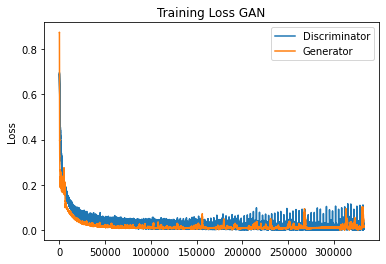

In [21]:
fig, ax = plt.subplots()
plt.plot(discriminator_loss, label='Discriminator')
plt.plot(gan_loss, label='Generator')
plt.title("Training Loss GAN")
plt.ylabel('Loss')
plt.legend()
plt.savefig(figure_path + 'loss_gan.png')

In [22]:
nr_batches_test = np.ceil(x_test.shape[0] // batch_size).astype(np.int32)

results = []

for t in range(nr_batches_test +1):
        ran_from = t * batch_size
        ran_to = (t + 1) * batch_size
        image_batch = x_test[ran_from:ran_to]             
        tmp_rslt = discriminator.predict(x=image_batch,batch_size=128,verbose=0)
        results = np.append(results, tmp_rslt)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 332700/332700 [55:40<00:00, 101.11it/s]

In [23]:
pd.options.display.float_format = '{:20,.7f}'.format
results_df = pd.concat([pd.DataFrame(results),pd.DataFrame(y_test)], axis=1)
results_df.columns = ['results','y_test']
print('Mean score for normal packets :', results_df.loc[results_df['y_test'] == 0, 'results'].mean() )
print('Mean score for anomalous packets :', results_df.loc[results_df['y_test'] == 1, 'results'].mean())

Mean score for normal packets : 0.9949599052044763
Mean score for anomalous packets : 0.9256749348810355


## Thresholds

In [24]:
#Obtaining the lowest "anomalies_percentage" score
per = np.percentile(results, anomalies_percentage*100)
y_pred = results.copy()
y_pred = np.array(y_pred)

In [25]:
#Thresholding based on the score
inds = (y_pred > per)
inds_comp = (y_pred <= per)
y_pred[inds] = 0
y_pred[inds_comp] = 1

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print('Accuracy Score :', accuracy_score(y_test, y_pred))
print('Precision :', precision)
print('Recall :', recall)
print('F1 :', f1)

Accuracy Score : 0.7938763934486519
Precision : 0.47725740031280045
Recall : 0.4772676725282136
F1 : 0.4772625363652343


In [26]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_curve = auc(fpr, tpr)

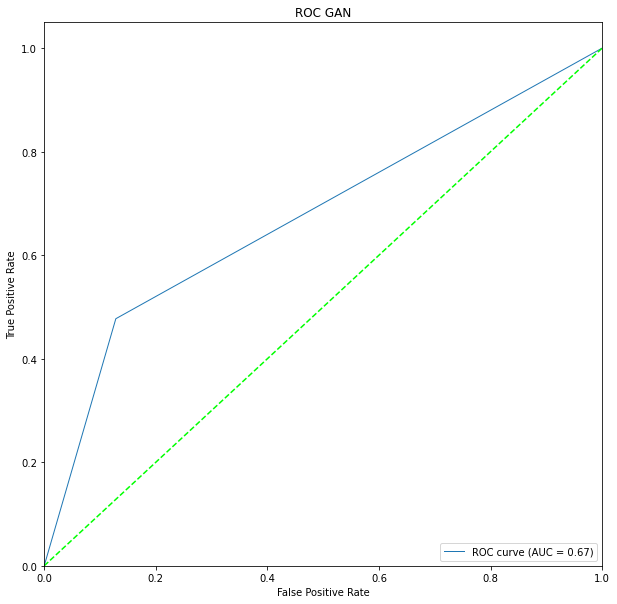

In [27]:
helper_functions.plot_roc(tpr, fpr, auc_curve, figure_path + 'confusion_gan.png', 'GAN')

In [28]:
cm = confusion_matrix(y_test, y_pred)

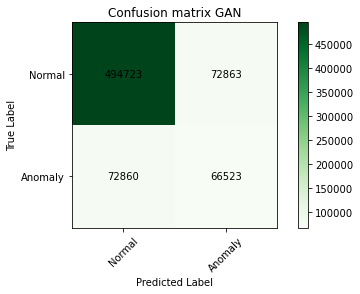

In [29]:
helper_functions.plot_confusion_matrix(cm, figure_path + 'confusion_gan.png', 'GAN')